In [500]:
import pandas as pd 
import os
from dateutil.relativedelta import relativedelta


def list_files(directory):
    paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            paths += [os.path.join(root, file)]
    return paths
#             print(os.path.join(root, file))

def get_null_columns(df):
    null_dict = {'field':[], 'proportion':[]}
    for col in df.columns:
        null_count = df[col].isnull().sum()
        prop = null_count / df.shape[0]
        
        null_dict['field'] += [col]
        null_dict['proportion'] += [prop]
        
    return pd.DataFrame(null_dict).sort_values(by='proportion', ascending=False)


# Function to determine and apply the appropriate aggregation method
def aggregate_by_dtype(df, groupby_cols):
    # Define custom aggregation function for mode
    def most_common(series):
        return series.mode()[0] if not series.mode().empty else np.nan

    # Dictionary to hold column names and their respective aggregation functions
    agg_funcs = {}

    # Loop through each column in the DataFrame
    for col in df.columns:
        # Skip columns used for grouping
        if col in groupby_cols:
            continue
        # Apply median for numeric columns
        if pd.api.types.is_numeric_dtype(df[col]):
            agg_funcs[col] = 'median'
        # Apply custom mode function for non-numeric (categorical) columns
        else:
            agg_funcs[col] = most_common

    # Group and aggregate the DataFrame
    aggregated_df = df.groupby(groupby_cols).agg(agg_funcs).reset_index()
    return aggregated_df



# Let's read in demographic data

https://wonder.cdc.gov/population-projections.html

In [216]:
#### 2019 Data ####

df_2019 = pd.read_csv('data/demographic/2019_demo.txt', sep='\t')
df_2019 = df_2019.drop('Notes',axis=1)
# df_2019.dropna(subset=['State'], inplace=True)
df_2019.dropna(subset=['State', 'Year', 'Age Group'])
# Pivot table
# Remove duplicate entries
df_2019.drop_duplicates(subset=['State', 'Year', 'Age Group'], inplace=True)

# Pivot table
df_pivoted = df_2019.pivot(index=['State', 'Year'], columns='Age Group', values='Projected Populations').reset_index()
# df_pivoted['Projected Populations'] = df_pivoted.sum(axis=1)
df_2019 = df_pivoted.dropna()

#### 2023 Data ####
df_2023 = pd.read_csv('data/demographic/2023_demo.txt', sep='\t')
df_2023 = df_2023.drop('Notes',axis=1)
# df_2019.dropna(subset=['State'], inplace=True)
df_2023.dropna(subset=['State', 'Year', 'Age Group'])
# Pivot table
# Remove duplicate entries
df_2023.drop_duplicates(subset=['State', 'Year', 'Age Group'], inplace=True)

# Pivot table
df_pivoted = df_2023.pivot(index=['State', 'Year'], columns='Age Group', values='Projected Populations').reset_index()

df_2023 = df_pivoted.dropna()

In [219]:
df_2023[df_2023['State']=='Alabama']
df_2019_2023['Year'].astype(str)

0      2019
1      2019
2      2019
3      2019
4      2019
       ... 
97     2023
98     2023
99     2023
100    2023
101    2023
Name: Year, Length: 102, dtype: object

### Straight line average on the monthly level

In [474]:
import pandas as pd
from datetime import datetime

df_2019_2023 = pd.concat([df_2019, df_2023], ignore_index=True).reset_index(drop=True)
# Convert the 'Year' column to datetime format
df_2019_2023['Year'] = df_2019_2023['Year'].astype(int).astype(str)

# df_2019_2023 = df_2019_2023.drop('index',axis=1)

static_cols = ['State', 'Year']
census_cols = ['0-4 years','10-14 years',  '15-19 years',  '20-24 years',  '25-29 years',
        '30-34 years',  '35-39 years',  '40-44 years',  '45-49 years',
          '5-9 years',  '50-54 years',  '55-59 years', '60-64 years ',
        '65-69 years',  '70-74 years',  '75-79 years',  '80-84 years','85+ years']

# Define the start and end dates (hard-coding these in)
start_date = datetime(2019, 4, 1)
end_date = datetime(2023, 4, 1)

total_months = (end_date.year - start_date.year) * 12 + end_date.month - start_date.month + 1 # Calculate the total number of months

result_df = pd.DataFrame() # Initialize an empty DataFrame for the results



for state in df_2019_2023['State'].unique():
#     print(state)
    state_df = df_2019_2023[df_2019_2023['State']==state]
    
    start_values = state_df.loc[state_df['Year'] == '2019', census_cols].iloc[0]
    end_values = state_df.loc[state_df['Year'] == '2023', census_cols].iloc[0]
    increments = (end_values - start_values) / (total_months - 1)
    
#     print(increments)
    
    # Generate new rows
    new_rows = []
    for month in range(total_months):
        monthly_values = start_values + increments * month
        new_row = monthly_values.to_dict()
        new_row.update(state_df.loc[state_df['Year'] == '2019', static_cols].iloc[0].to_dict())  # Update with static values
        new_row['date'] = start_date + pd.DateOffset(months=month)
        new_rows.append(new_row)
 
        # Append new rows to the result DataFrame
    result_df = pd.concat([result_df, pd.DataFrame(new_rows)], ignore_index=True)

demo_df = result_df
demo_df['year'] = demo_df['date'].dt.year
demo_df['month'] = demo_df['date'].dt.month

demo_df = demo_df.rename(columns={'State':'state'})

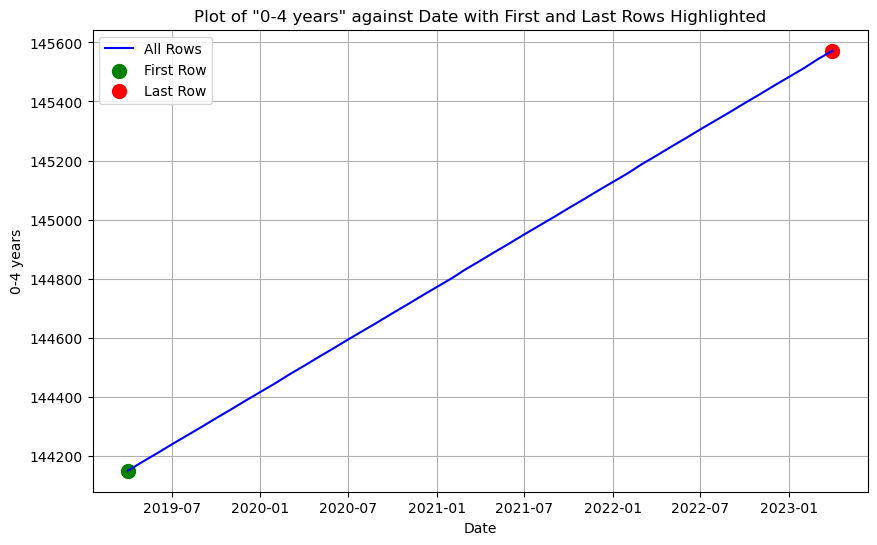

In [236]:
test_df = demo_df[['State','Year', 'date', '0-4 years' ]].sort_values(['State','date'])
test_df=test_df[test_df['State']=='Alabama']
first_row = test_df.head(1)

# Last row
last_row = test_df.tail(1)

# little sanity check 
print(df_2023[df_2023['State']=='Alabama']['0-4 years'], first_row['0-4 years'])

import matplotlib.pyplot as plt

test_df = result_df[['State','Year', 'date', '0-4 years' ]].sort_values(['State','date'])
test_df=test_df[test_df['State']=='Alabama']
first_row = test_df.head(1)

# Last row
last_row = test_df.tail(1)
# Plot all rows
plt.figure(figsize=(10, 6))

# Plotting all rows
plt.plot(test_df['date'], test_df['0-4 years'], label='All Rows', color='blue')

# Highlight first row
plt.scatter(first_row['date'], first_row['0-4 years'], color='green', label='First Row', s=100)

# Highlight last row
plt.scatter(last_row['date'], last_row['0-4 years'], color='red', label='Last Row', s=100)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('0-4 years')
plt.title('Plot of "0-4 years" against Date with First and Last Rows Highlighted')
plt.legend()
plt.grid(True)
plt.show()


## Population Estimates (projections)

https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-total.html


In [480]:
pop_df = pd.read_csv('data/demographic/NST-EST2022-ALLDATA.csv')
pop_df = pop_df[pop_df['NAME'].isin(demo_df['state'].unique())]

pop_df.columns

keep = ['POPESTIMATE2020', 'POPESTIMATE2021', 'POPESTIMATE2022','State']
pop_df['state'] = pop_df['NAME']

pop_dict = {'state':[], 'year':[], 'PopEstimate':[]}
for idx,row in pop_df.iterrows():
    pop_dict['state'] += [row['state']]
    pop_dict['year'] += [2020]
    pop_dict['PopEstimate'] += [row['POPESTIMATE2020']]
    
    pop_dict['state'] += [row['state']]
    pop_dict['year'] += [2021]
    pop_dict['PopEstimate'] += [row['POPESTIMATE2021']]
    
    pop_dict['state'] += [row['state']]
    pop_dict['year'] += [2022]
    pop_dict['PopEstimate'] += [row['POPESTIMATE2022']]
    
pop_df = pd.DataFrame(pop_dict)


## Load in Covid policy datasets

In [482]:
covid_df = pd.read_csv('data/demographic/covid.csv')

covid_df['date'] = pd.to_datetime(covid_df['Date'], format='%Y%m%d')
covid_df = covid_df[covid_df['RegionName'].notna()]
null_df = get_null_columns(covid_df)
covid_df = covid_df[null_df[null_df['proportion'] == 0.0]['field'].values]

# Extract year and month from 'Date' column
covid_df['year'] = covid_df['date'].dt.year
covid_df['month'] = covid_df['date'].dt.month
covid_df.columns
groupby_cols = ['year', 'month', 'RegionCode', 'RegionName', 'CountryName', 'Jurisdiction', 'CountryCode']
covid_aggregated_df = aggregate_by_dtype(covid_df, groupby_cols)
covid_aggregated_df = covid_aggregated_df.rename(columns={'RegionName':'state'})
# print(covid_aggregated_df['month'].unique(),aggregated_df['month'].unique())

# Combine Data
* New york times dataset (deaths)
* CDC Vaccine Info
* CDC population projects

In [469]:
# Read in vaccine information
df_vaccines = pd.read_csv('data/cdc_vaccines_distributed_administered_by_jurisdiction_timeseries.csv')
df_vaccines['date'] = pd.to_datetime(df_vaccines['date'])
df_vaccines['month'] = df_vaccines['date'].dt.month
df_vaccines['year'] = df_vaccines['date'].dt.year
df_vaccines['date'] = df_vaccines['date'].dt.to_period('M').dt.to_timestamp()
df_vaccines = df_vaccines.groupby(['state_name', 'state_abbreviation', 'date']).sum().reset_index().sort_values(['date', 'state_name'])
df_vaccines = df_vaccines.rename(columns={'state_name':'state'})
df_vaccines.columns

Index(['state', 'state_abbreviation', 'date', 'index',
       'doses_distributed_cumulative', 'doses_administered_cumulative',
       'new_doses_distributed', 'new_doses_administered',
       'new_doses_distributed_7_day_rolling_avg',
       'new_doses_administered_7_day_rolling_avg', 'month', 'year'],
      dtype='object')

In [564]:
### Read in NYT deaths dataset: https://github.com/nytimes/covid-19-data/blob/master/us-states.csv

deaths_df = pd.read_csv('data/demographic/us-states.csv')

deaths_df['date'] = pd.to_datetime(deaths_df['date'])
deaths_df['date'] = deaths_df['date'].dt.to_period('M').dt.to_timestamp()
deaths_df= deaths_df.drop_duplicates(subset=['date', 'state', 'fips', 'cases', 'deaths'])
deaths_df = deaths_df.groupby(['state', 'date']).sum().reset_index().sort_values(['date', 'state'])
deaths_df['month'] = deaths_df['date'].dt.month
deaths_df['year'] = deaths_df['date'].dt.year

In [565]:
#### Combine deaths and vaccines table ####
aggregated_df = pd.merge(deaths_df, df_vaccines, on = ['state','month', 'year'], how ='inner' )

## Next is CDC population projections 
aggregated_df = pd.merge(aggregated_df, demo_df, on=['month', 'year', 'state'], how='inner')

## Now combine yearly popualtion data 
aggregated_df = pd.merge(aggregated_df, pop_df, on=['year', 'state'], how='left')

## Finally, let's join with Covid data
aggregated_df = pd.merge(aggregated_df, covid_aggregated_df, on=['year','month','state'],suffixes=('_agg', '_covid'))


aggregated_df['death_prop'] = (aggregated_df['deaths'] / aggregated_df['PopEstimate'])*100
aggregated_df['death_event'] = (aggregated_df['death_prop'] >= 8).astype(int)

aggregated_df.to_csv('Data/ModelingData/final_final_final_draft.csv')

In [566]:
aggregated_df['deaths'] / aggregated_df['PopEstimate']

0       0.026201
1       0.006747
2       0.033087
3       0.031599
4       0.017314
          ...   
1245    0.057524
1246    0.019146
1247    0.087558
1248    0.048204
1249    0.020097
Length: 1250, dtype: float64

In [553]:
## Now let's create the region field


region_mapping = {
    'West': ['California', 'Oregon', 'Washington', 'Nevada', 'Arizona', 'Alaska', 'Hawaii', 'Idaho', 'Montana', 'Wyoming', 'Utah', 'Colorado'],
    'Midwest': ['North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Minnesota', 'Iowa', 'Missouri', 'Wisconsin', 'Illinois', 'Indiana', 'Michigan', 'Ohio'],
    'Southwest': ['Texas', 'Oklahoma', 'New Mexico'],
    'Southeast': ['Florida', 'Georgia', 'South Carolina', 'North Carolina', 'Virginia', 'West Virginia', 'Maryland', 'Delaware', 'Kentucky', 'Tennessee', 'Alabama', 'Mississippi', 'Louisiana', 'Arkansas'],
    'Northeast': ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'New Jersey', 'Pennsylvania']
}

def get_region(state):
    """Assigns a region based on the provided state."""
    for region, states in region_mapping.items():
        if state in states:
            return region
    return 'Unknown'  # For states not in the mapping

# Assuming your DataFrame is named 'df' and has a 'state' column:
aggregated_df['region'] = aggregated_df['state'].apply(get_region)


def calculate_num_months(min_date, row):
    date2 = row['date_agg']
    delta = relativedelta(date2, min_date)
    months = delta.years * 12 + delta.months
    return months

min_date = aggregated_df['date_agg'].min()


aggregated_df['num_months'] = aggregated_df.apply(lambda row: calculate_num_months(min_date, row), axis=1)

aggregated_df.columns

Index(['state', 'date_x', 'fips', 'cases', 'deaths', 'month', 'year',
       'state_abbreviation', 'date_y', 'index', 'doses_distributed_cumulative',
       'doses_administered_cumulative', 'new_doses_distributed',
       'new_doses_administered', 'new_doses_distributed_7_day_rolling_avg',
       'new_doses_administered_7_day_rolling_avg', '0-4 years', '10-14 years',
       '15-19 years', '20-24 years', '25-29 years', '30-34 years',
       '35-39 years', '40-44 years', '45-49 years', '5-9 years', '50-54 years',
       '55-59 years', '60-64 years ', '65-69 years', '70-74 years',
       '75-79 years', '80-84 years', '85+ years', 'Year', 'date_agg',
       'PopEstimate', 'RegionCode', 'CountryName', 'Jurisdiction',
       'CountryCode', 'V3_Vaccine Financial Support (summary)',
       'V1_Vaccine Prioritisation (summary)',
       'V2A_Vaccine Availability (summary)',
       'H8M_Protection of elderly people', 'H7_Vaccination policy', 'Date',
       'C1M_School closing', 'C2M_Workplace clo

In [555]:
region_mapping.keys()

dict_keys(['West', 'Midwest', 'Southwest', 'Southeast', 'Northeast'])

In [554]:
# df = pd.read_csv('data/ModelingData/covid_modeling_data.csv')
drop_columns = ['date_x', 'fips','state_abbreviation', 'date_y', 'index', 'date_agg'
                ,'CountryName', 'Jurisdiction','CountryCode','Date','date_covid', 'death_prop'
                , 'RegionCode', 'deaths'
               ]

aggregated_df = aggregated_df.drop(drop_columns,axis=1)


aggregated_df.columns

aggregated_df.to_csv('Data/ModelingData/covid_dataset_final_3_6_24.csv')

In [543]:

test = aggregated_df.loc[aggregated_df['death_prop'] >= 8]

test = test['state'].unique()

len(test)

# all_states = aggregated_df['state'].unique()

# states_missing_death_event = set(all_states) - set(states_without_death_event)

# states_missing_death_event

20

In [562]:
# len(aggregated_df.columns)
aggregated_df.num_months.min()

0